<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/Michael/Airbnb_Data_Base_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuration and library set-up**

In [2]:
# set up working directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Airbnb_Milestone2

# data manipulation
import pandas as pd
import numpy as np 
import re # regex
pattern = '\w+' # default regex pattern
import random
import string
from collections import Counter, defaultdict
from itertools import chain

# machine learning
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# timeit
from tqdm import tqdm

# data visualisation
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# NLP
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))
nltk.download('punkt')     # comment out if already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Language Detection

!pip install fasttext
import fasttext
# setting up the pretrained model
fasttxt_model = fasttext.load_model("lid.176.bin")

!pip install pycld2
import pycld2 as cld2

# VADER sentiment tagging 
nltk.downloader.download('vader_lexicon')
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# helper function to remove HTML tags from comments
from bs4 import BeautifulSoup

# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1wUOfFY-ki2nFzneeaTtXLEeMjaSdKrrj/Airbnb_Milestone2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3163403 sha256=f8d92aed3b634157b7e0c3876214d7217ea276b558d3c1aa52e3a658bdad7524
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.4 MB 1.8 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834269 sha256=6a5419dc36a2e61d47d863763f569bc30239547d19d4ced6c194dcadbb3619a5
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.4 MB/s 


In [2]:
# read data
reviews_df = pd.read_csv('Datasets/reviews.csv') 
# remove white spaces in column headings
reviews_df.columns = reviews_df.columns.str.strip() 
# Examine dataset
display(reviews_df.head(10))
display(reviews_df.shape)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,52228441,623723762668719111,2022-05-10,37052865,Kimberly,"Great location, and the host was very responsi..."
1,52228441,505671819125096360,2021-11-28,70830110,Mahelet,Duccio is a lovely and friendly host. From arr...
2,52228441,466510411892882382,2021-10-05,83617224,Will,Duccio is a good communicator… he was very hel...
3,52228441,604109461995958546,2022-04-13,2152541,Francesco,Not entirely compliant to the pics.<br/>Good l...
4,605617198416835367,633128504578904919,2022-05-23,45418187,Waddah,Great place and great host
5,52228441,488275073602903479,2021-11-04,37185586,Ruslans,The flat is very well connected to the city by...
6,17501535,668631693343526023,2022-07-11,5132271,Marc,Nice place
7,52228441,588257361951713358,2022-03-22,248672143,Sveinung,Big apartment but a little bit run down. Kitc...
8,17501535,633193507110858827,2022-05-23,413544004,Daniel,"Amazing place, we loved it. Tons of space, nic..."
9,52228441,491866989310660615,2021-11-09,8452946,Johnny,"Duccio was a great host, super friendly with l..."


(1216212, 6)

# **Data Cleaning**

**Steps to follow**

1.   Drop rows containing NAN values (DONE)
2.   Drop rows with empty string for 'comments' column (DONE)
3.   Remove HTML tags from string in 'comments' column (DONE)
4.   Remove special characters including emojis from strings (DONE)
5.   Drop rows containing non-english string in 'comments' column (DONE)





In [3]:
# check if there is any null value 
reviews_df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     2
comments         92
dtype: int64

In [4]:
# check if there is any empty string in the comments column
reviews_df.loc[reviews_df["comments"] == "."]

,listing_id,id,date,reviewer_id,reviewer_name,comments
92,21526298,675869744229404323,2022-07-21,215666012,David,.
319,32537244,572622781,2019-12-03,310625523,Fernando,.
2388,3370968,551274991374749641,2022-01-30,88466671,Bekee,.
3143,13396482,562849095,2019-11-11,299309771,Cecilie,.
3334,41509,49170962,2015-10-01,736090,Alberto,.
...,...,...,...,...,...,...
1209963,31495400,518304382,2019-08-26,34520842,Augusto,.
1212428,31201633,419606016,2019-03-04,243989008,Javier,.
1212852,31304270,419096711,2019-03-03,244943897,Bernard,.
1214589,32002019,474417589,2019-06-23,64631352,Margaret,.


In [5]:
# Drop the null value and comments value with "."
reviews_df = reviews_df[reviews_df['comments'].notna()]
display(reviews_df.shape)

(1216120, 6)

---
92 Comments containing null value dropped

In [6]:
# Drop the rows with empty string for comments column
reviews_df = reviews_df.loc[reviews_df["comments"] != "."]
display(reviews_df.shape)

(1214643, 6)

---
1477 Comments containing empty string dropped

In [7]:
# helper function to remove HTML tags from comments
copy_df = reviews_df.copy()
#small_df = copy_df.iloc[:100,]
copy_df['comments'] = copy_df['comments'].apply(lambda s: BeautifulSoup(s).text)
#display(copy_df.head(100))

In [8]:
# removing special characters including punctuations and emojis. 
copy2_df = copy_df.copy()

copy2_df['comments'] = copy2_df['comments'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
copy2_df.columns = copy2_df.columns.str.strip() 

#display(copy2_df)


# **Comments Language Identification**

In [9]:
# settting up the pretrained model
fasttxt_model = fasttext.load_model("lid.176.bin")

In [10]:
# test model with example text
fasttxt_model.predict('이 집은 정말 좋아요! 맘에 쏙 드네요')[0][0][-2:]

'ko'

In [11]:
# Adding an extra column for language identification
copy2_df['lang'] = copy2_df['comments'].apply(lambda x: fasttxt_model.predict(x)[0][0][-2:])
display(copy2_df)

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang
0,52228441,623723762668719111,2022-05-10,37052865,Kimberly,"Great location, and the host was very responsi...",en
1,52228441,505671819125096360,2021-11-28,70830110,Mahelet,Duccio is a lovely and friendly host. From arr...,en
2,52228441,466510411892882382,2021-10-05,83617224,Will,Duccio is a good communicator he was very help...,en
3,52228441,604109461995958546,2022-04-13,2152541,Francesco,Not entirely compliant to the pics.Good locati...,en
4,605617198416835367,633128504578904919,2022-05-23,45418187,Waddah,Great place and great host,en
...,...,...,...,...,...,...,...
1216207,14832630,184884203,2017-08-20,54407484,丽云,干净舒适适合家庭入住地段优越景点全部很多都可以步行到达节省了交通费房间设施齐备能满足我们的一...,en
1216208,14832630,173531056,2017-07-23,130284505,Véronique,Excellente situation au plein centre de Londre...,fr
1216209,14832630,153170957,2017-05-20,119296298,Nicole,"Todo perfecto Ubicación, comodidad y Rachel c...",es
1216210,14832630,145456398,2017-04-18,16394435,Christophe,Tout dabord même si nous navons pas eu le plai...,fr


In [12]:
# calculating number of rows with non-english comments 
display(copy2_df.lang.value_counts())
prop = (1214643-1089747)/1214643*100
f'The total non-english comments proportion is {prop}.'

en    1089747
fr      45182
es      22556
de      16384
it      10215
       ...   
br          1
mk          1
ne          1
io          1
ms          1
Name: lang, Length: 77, dtype: int64

'The total non-english comments proportion is 10.282527458685392.'

---
**The total non-english comments proportion is 10.28%. 
Therefore, it is safe to drop the rows with non-english comments.**




In [13]:
# keeping only rows with English comments
copy3_df = copy2_df[copy2_df['lang']=='en']
#display(copy3_df)

In [14]:
# Special case that has both chinese and English
display(copy3_df.loc[[1216207]])

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang
1216207,14832630,184884203,2017-08-20,54407484,丽云,干净舒适适合家庭入住地段优越景点全部很多都可以步行到达节省了交通费房间设施齐备能满足我们的一...,en


In [15]:
# drop rows containing multiple languages
copy3_df['Deteced_lang'] = copy3_df['comments'].map(lambda a: cld2.detect(a,bestEffort=True)[2][1][0])
copy3_df = copy3_df[copy3_df['Deteced_lang']=='Unknown']
#copy4_df.comments.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
#display(copy3_df)

In [16]:
# drop rows containing non-meaningful words
copy3_df['Deteced_lang'] = copy3_df['comments'].map(lambda a: cld2.detect(a, bestEffort=True)[2][0][0])
copy3_df = copy3_df[copy3_df['Deteced_lang']!='Unknown']

In [17]:
copy3_df = copy3_df.drop('Deteced_lang',axis=1)
#display(copy3_df)

# **Data Preprocessing**


*   Punctuation removal
*   Stopwords removal
*   Lowercase
*   Lemmatization
*   Tokenization



In [18]:
# Data pre-processing using conventional method (ok accuracy / fast speed)
def clean_text(comments):
  punc = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""
  punc_removed = [char for char in comments if char not in punc]
  punc_join = ''.join(punc_removed)
  cleaned = []
  splitted = comments.split()
  for x in splitted:
    if x.isalpha() and x not in stop_words:
      cleaned.append(x.lower())
  result = ' '.join(cleaned)
  return result

In [19]:
%%time
copy3_df['cleaned_comments'] = copy3_df['comments'].apply(clean_text)

CPU times: user 27.6 s, sys: 129 ms, total: 27.8 s
Wall time: 27.8 s


In [20]:
#display(copy3_df)

In [21]:
# Data pre-processing using spacy (great accuracy / slow speed)
import spacy
#!python -m spacy download en_core_web_trf
nlp = spacy.load("en_core_web_sm",disable=['tagger', 'parser', 'ner'])
def spacyClean(doc,stemming = False):
    #doc = doc.lower()
    doc = nlp(doc)
    tokens = [tokens.lower_ for tokens in doc]
    tokens = [tokens for tokens in doc if (tokens.is_stop == False)]
    tokens = [tokens for tokens in tokens if (tokens.is_punct == False)]
    final_token = [token.lemma_ for token in tokens]
    return " ".join(final_token)

In [22]:
%%time
#copy3_df['cleaned_comments_spacy'] = copy3_df['comments'].apply(spacyClean)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


## **This should go after analyzer**

###########################################################

In [49]:
# Data pre-processing using nltk (good accuracy / ok speed)

def clean_up(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im','i']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)
    tokens = nltk.word_tokenize(final_string)

    return tokens

In [24]:
%%time
copy3_df['cleaned_comments_nltk'] = copy3_df['comments'].apply(clean_up, stem='Lem')

CPU times: user 7min 44s, sys: 19.4 s, total: 8min 3s
Wall time: 8min 4s


###########################################################

In [25]:
display(copy3_df[['comments','cleaned_comments','cleaned_comments_nltk']])

,comments,cleaned_comments,cleaned_comments_nltk
0,"Great location, and the host was very responsi...",great host responsive,"[great, location, host, responsive, helpfulhugh]"
1,Duccio is a lovely and friendly host. From arr...,duccio lovely friendly from arrival instructio...,"[duccio, lovely, friendly, host, arrival, inst..."
2,Duccio is a good communicator he was very help...,duccio good communicator helpful making stay g...,"[duccio, good, communicator, helpful, making, ..."
3,Not entirely compliant to the pics.Good locati...,not entirely compliant location basic shower w...,"[entirely, compliant, picsgood, location, basi..."
4,Great place and great host,great place great host,"[great, place, great, host]"
...,...,...,...
1216193,We had a really great stay in Rachels central ...,we really great stay rachels central clean wel...,"[really, great, stay, rachel, central, apartme..."
1216194,"This was an excellent apartment. Very clean, w...",this excellent very well equipped location par...,"[excellent, apartment, clean, well, equipped, ..."
1216195,The place was a dream come true\r Its newly re...,the place dream come true its newly even flowe...,"[place, dream, come, true, newly, renovated, s..."
1216196,Her place is so greatNice and clean. My wife a...,her place greatnice my wife wonderful,"[place, greatnice, clean, wife, wonderful, time]"


**VADER Sentiment Tagging**

The result generated by VADER is a dictionary of 4 keys neg, neu, pos and compound:

neg, neu, and pos meaning negative, neutral, and positive respectively. Their sum should be equal to 1 or close to it with float operation.

compound corresponds to the sum of the valence score of each word in the lexicon and determines the degree of the sentiment rather than the actual value as opposed to the previous ones. Its value is between -1 (most extreme negative sentiment) and +1 (most extreme positive sentiment). Using the compound score can be enough to determine the underlying sentiment of a text, because for:

a positive sentiment, compound ≥ 0.05

*   a positive sentiment, compound ≥ 0.05
*   a negative sentiment, compound ≤ -0.05
*   a neutral sentiment, the compound is between [-0.05, 0.05]


Creating function to tag sentiment based on VADER compound score

In [26]:
def sentiment_tag(row):
  if row['VADER_compound_score'] >= 0.05:
    sentiment = "Positive"
  elif row['VADER_compound_score'] <= -0.05:
    sentiment = "Negative"
  else:
    sentiment = "Neutral"
  return sentiment

Applying the VADER Analyzer on raw comments to capture sentiments fully (e.g ! to reflect excitement, etc)

In [27]:
%%time
#copy3_df['VADER_compound_score'] = [round(SentimentIntensityAnalyzer().polarity_scores(x)['compound'], 2) for x in copy3_df['comments']]

CPU times: user 2h 34min 28s, sys: 2min 53s, total: 2h 37min 22s
Wall time: 2h 37min 29s


Create new col in pandas df to apply function to compound score

In [28]:
copy3_df['sentiment'] = copy3_df.apply(sentiment_tag, axis = 1)

In [31]:
%%time
#cleaned_df = copy3_df
#cleaned_df.to_csv('cleaned_df.csv')

CPU times: user 19.1 s, sys: 1.38 s, total: 20.4 s
Wall time: 32.4 s


**Sentiment - Descriptive Statistics**

In [45]:
cleaned_df.groupby('sentiment')['VADER_compound_score'].agg(['count','mean','median']).reset_index()

,sentiment,count,mean,median
0,Negative,16185,-0.523624,-0.51
1,Neutral,25786,0.000119,0.00
2,Positive,1045528,0.856456,0.92


**Proportion of sentiment in sample: Proxy**

In [37]:
for sentiment in cleaned_df.sentiment.unique():
  print("% of "+ str(sentiment) + " in sample df:", len(cleaned_df[cleaned_df.sentiment == sentiment])/len(cleaned_df)*100)

% of Positive in sample df: 96.14059415227048
% of Neutral in sample df: 2.371128617129763
% of Negative in sample df: 1.4882772305997523


Observing if VADER Compound score has any relationship with length of review

In [6]:
# creating new column for length of original review 
%%time
#cleaned_df['review_length'] = cleaned_df['comments'].apply(word_tokenize).tolist()
#cleaned_df['review_length'] = cleaned_df['review_length'].apply(len)

CPU times: user 6min 1s, sys: 7.47 s, total: 6min 8s
Wall time: 6min 11s


In [50]:
%%time
cleaned_df = pd.read_csv('cleaned_df.csv', lineterminator ='\n')
cleaned_df['cleaned_comments_nltk'] = cleaned_df['comments'].apply(clean_up, stem='Lem')

CPU times: user 11min 19s, sys: 28.5 s, total: 11min 48s
Wall time: 11min 51s


**Plotting word distribution for each sentiment (Zipf's Law)**

In [59]:
def word_occurence_chart(df, senti, top_n):

  from itertools import chain
  df = df.loc[df['sentiment'] == senti] 
  dict_words = Counter(chain(*df.cleaned_comments_nltk))
  top_N = dict_words.most_common(top_n)

  x = list(range(0, top_n))

  sum_ = 0
  for i,value in top_N:
    sum_ += value

  y = []
  for i,value in top_N:
    y.append(value/sum_)
  
  ax = plt.plot(x, y, '.')
  plt.yscale('log')
  plt.xscale('log')
  plt.show()
  print(top_N)




**For positive sentiment:**

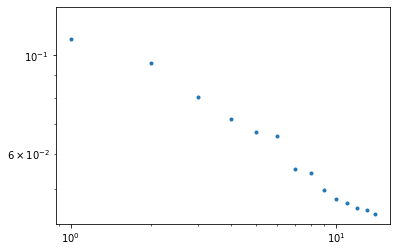

[('great', 570678), ('stay', 507428), ('place', 449551), ('location', 376010), ('host', 335669), ('clean', 314720), ('london', 306910), ('room', 258752), ('nice', 254249), ('would', 232855), ('flat', 222517), ('apartment', 217045), ('good', 211795), ('recommend', 209416), ('lovely', 205455)]


In [60]:
word_occurence_chart(cleaned_df, "Positive", 15)

**For negative sentiment:**

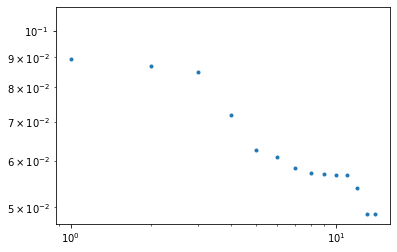

[('room', 8192), ('place', 6935), ('stay', 6743), ('host', 6589), ('apartment', 5569), ('u', 4853), ('would', 4730), ('one', 4525), ('flat', 4434), ('day', 4423), ('night', 4404), ('location', 4396), ('bed', 4173), ('time', 3778), ('airbnb', 3774)]


In [61]:
word_occurence_chart(cleaned_df, "Negative", 15)

**For Neutral Sentiment:**

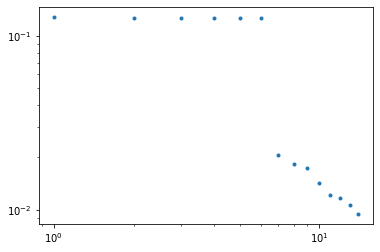

[('day', 13305), ('host', 13189), ('arrival', 13049), ('reservation', 12986), ('canceled', 12985), ('automated', 12951), ('posting', 12950), ('place', 2131), ('stay', 1895), ('location', 1783), ('room', 1460), ('close', 1248), ('convenient', 1199), ('london', 1094), ('station', 973)]


In [62]:
word_occurence_chart(cleaned_df, "Neutral", 15)

**Split dataset into test, train and dev**

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively. Our random seed will be initialised as 42.

In [63]:
RANDOM_SEED = 42

In [72]:
fractions = np.array([0.8, 0.1, 0.1])
df = cleaned_df.sample(frac = 1, random_state = RANDOM_SEED) # shuffle data
df = df[['cleaned_comments','sentiment']].dropna() # drop na rows after cleaning (500+)

# split into training, validation and testing sets
train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

assert len(train_df) + len(val_df) + len(test_df) == len(df)

**Convert text data to features - TF-IDF**

In [85]:
%%time
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 50)
X_train = vectorizer.fit_transform(train_df.cleaned_comments)
print(X_train.shape)

(869567, 8316)
CPU times: user 17.9 s, sys: 167 ms, total: 18 s
Wall time: 18.6 s


**Get the list of labels**

In [81]:
y_train = list(train_df.sentiment)
print(len(y_train))

869567


**Fit the classifier on the data**

In [86]:
%%time
clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', random_state = RANDOM_SEED)
clf.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 21.5 s, total: 1min 24s
Wall time: 1min 9s


LogisticRegression(random_state=42)

**Generate validation data**

In [89]:
%%time
X_val = vectorizer.transform(val_df.cleaned_comments)
y_val = list(val_df.sentiment)

CPU times: user 2.96 s, sys: 20.1 ms, total: 2.98 s
Wall time: 3 s


**Generate logistic regression prediction**

In [91]:
lr_pred = clf.predict(X_val)
lr_f1 = f1_score(y_val, lr_pred, average = 'macro')
print(lr_f1)

0.7749032634344606
